In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.linalg import inv
from scipy.signal import find_peaks
from scipy.integrate import solve_ivp
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

sys.path.append('./../../tensor-dynamic-univariate-ts-pytorch/')
from tensordynamicmodel.visuals import plot_phase_trajectory, delay_embedding_matrix
from tensordynamicmodel.utils import delay_embedding_matrix, diag_mean, prepare_time_series, lorenz

In [2]:
# plt.rcParams['font.family'] = 'DejaVu Serif'
# plt.rcParams.update({"text.usetex": False})

In [3]:
class LorenzSystem:
    def __init__(self, sigma=10.0, beta=8/3, rho=28.0):
        self.sigma = sigma
        self.beta = beta
        self.rho = rho
    
    def equation(self, t, state):
        x, y, z = state
        dx_dt = self.sigma * (y - x)
        dy_dt = x * (self.rho - z) - y
        dz_dt = x * y - self.beta * z
        return [dx_dt, dy_dt, dz_dt]
    
    def generate_data(self, initial_state, t_span, n_points=10000):
        t_eval = np.linspace(t_span[0], t_span[1], n_points)
        solution = solve_ivp(self.equation, t_span, initial_state, 
                           t_eval=t_eval, method='RK45')
        return solution.t, solution.y

In [4]:
def moving_average_simple(data, window_size):
    """
    Простая реализация скользящего среднего
    """
    moving_avg = []
    for i in range(len(data)):
        if i < window_size - 1:
            # Для первых элементов недостаточно данных
            moving_avg.append(np.nan)
        else:
            # Вычисляем среднее для окна
            window = data[i - window_size + 1:i + 1]
            moving_avg.append(np.mean(window))
    return np.array(moving_avg)
    
def make_ts(person, activity):
    pdf_data_all = pd.read_csv(f'./../data/A_DeviceMotion_data/{activity}/sub_{person}.csv').reset_index(drop=True)
    data_list = ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']
    data_list_short = ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']
    pdf_data_all = pdf_data_all[data_list_short]
    xyz = pdf_data_all[data_list_short].to_numpy()
    x, y, z = xyz[:,0], xyz[:,1], xyz[:,2]
    return (x**2 + y**2 + z**2)**0.5

def acc_ts_alignment(x, trashhold = 2):
    x = (x - x.mean())/(x.var()**.5)
    i_peak, _ = find_peaks(x)
    i_min_peak = [i for i in i_peak if x[i] >= trashhold]
    return i_min_peak[0]

# def prepare_ts(person, activity, trashhold= 2):
#     ts = make_ts(person, activity)
#     i_min_peak = acc_ts_alignment(ts[500:800], trashhold)
#     ts = ts[500+i_min_peak-20:] 
#     ts = moving_average_simple(ts, 20)[20:]
#     return ts

In [5]:
def compute_jacobian_matrix(S_old, S_new):
    """Вычисление матрицы Якоби между двумя фазовыми пространствами"""
    # Решаем задачу линейной регрессии: S_new ≈ S_old*J
    J_est = inv(S_old.T @ S_old) @ S_old.T @ S_new  
    return J_est
    
def jacobian_prediction_model(train_static_params, J_matrices, test_static_params):
    """Модель предсказания матрицы Якоби по параметру rho"""
    # Векторизация матриц Якоби
    J_vecs = np.array([J.flatten() for J in J_matrices])
    
    # Обучение линейной модели
    model = LinearRegression()
    model.fit(rho_values.reshape(-1, 1), J_vecs)
    
    # Предсказание для нового rho
    J_pred_vec = model.predict(np.array([[test_rho]]))
    J_pred = J_pred_vec.reshape(3, 3)
    
    return J_pred

In [43]:
# def prepare_ts(person, activity, trashhold= 2):
#     ts = make_ts(person, activity)
#     i_min_peak = acc_ts_alignment(ts[500:800], trashhold)
#     ts = ts[500+i_min_peak-20:] 
#     ts = moving_average_simple(ts, 20)[20:]
#     return ts

def prepare_ts(person, activity, global_start_point, global_end_point, person_start_point_map_500):
    ts = make_ts(person, 'wlk_15')[global_start_point+person_start_point_map_500[person]-20:global_end_point]
    ts = moving_average_simple(ts, 20)[20:]
    return ts

In [44]:
global_start_point = 500
global_end_point = 3000
person_start_point_map_500 = {
    1: 5-1,
    2: 6,
    3: 9,
    4: 45,
    5: 13-4,
    6: 16,
    7: 63,
    8: 68,
    9: 69,
    10: 47,
    11: 29,
    12: 40,
    13: 44-5,
    14: 13,
    15: 49,
    16: 3-1,
    17: 13,
    18: 8,
    19: 26+10,
    20: 40,
    21: 46,
    22: 16,
    23: 47-8,
    24: 34-6
}

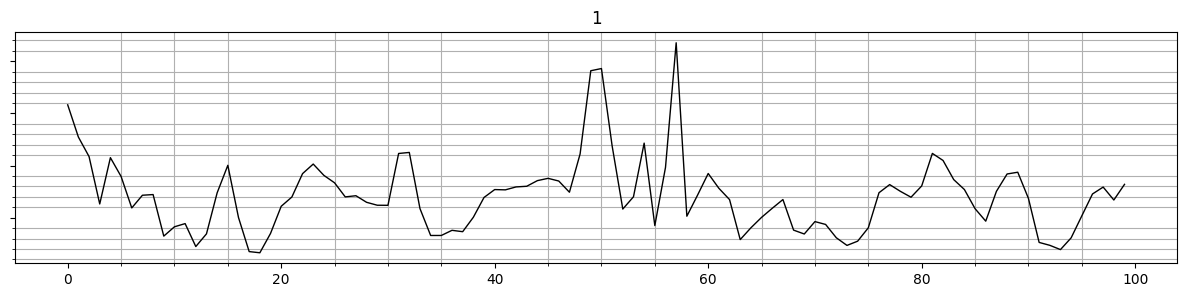

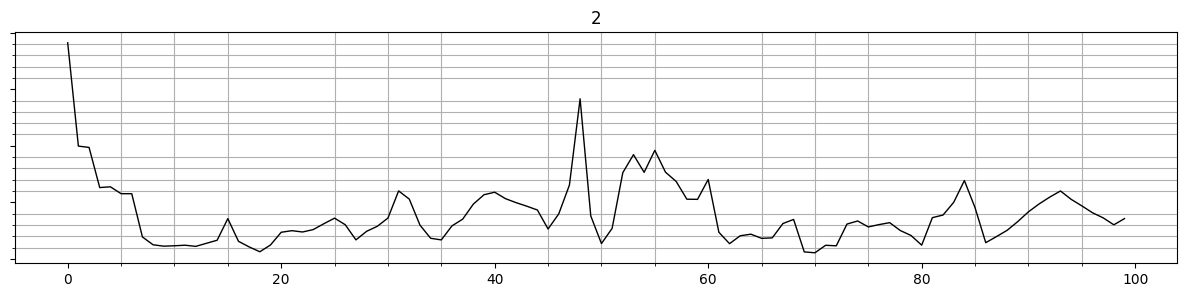

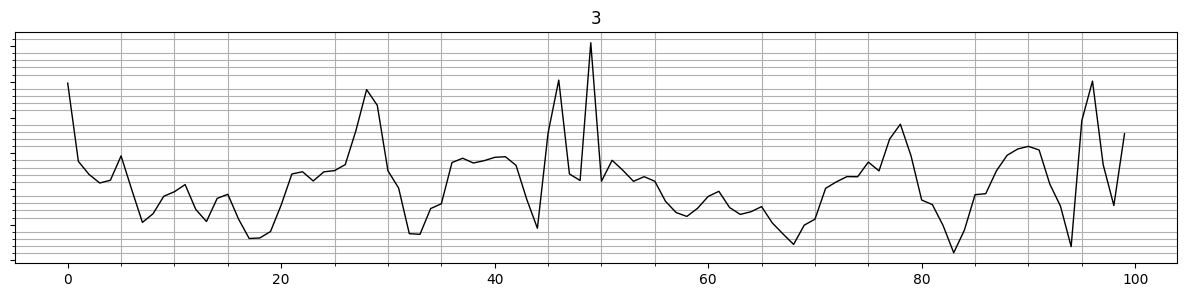

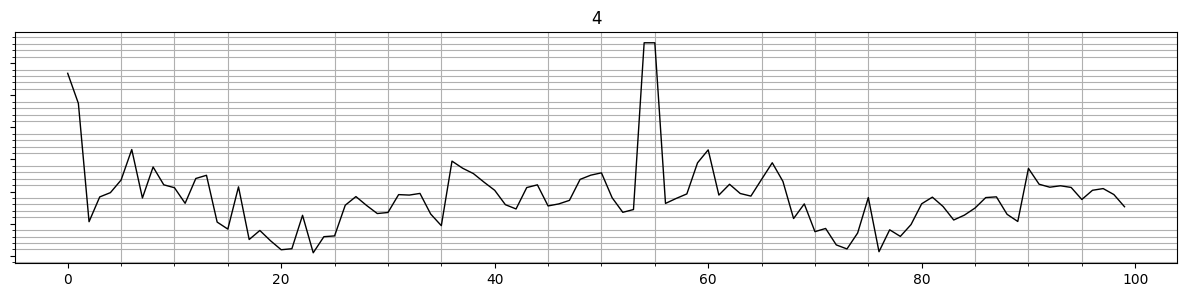

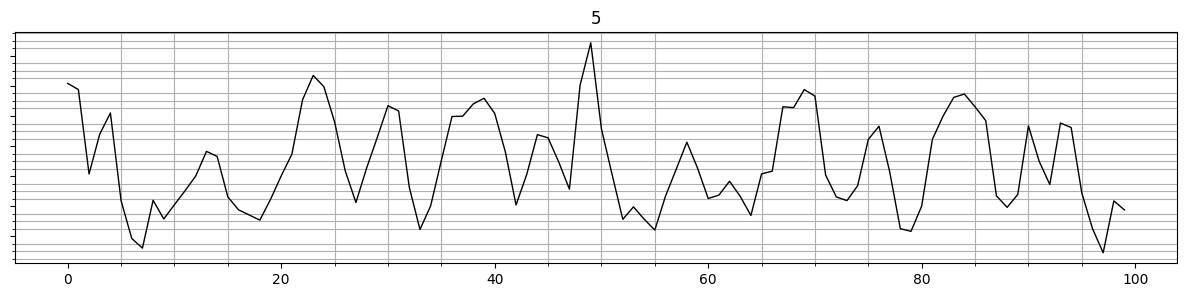

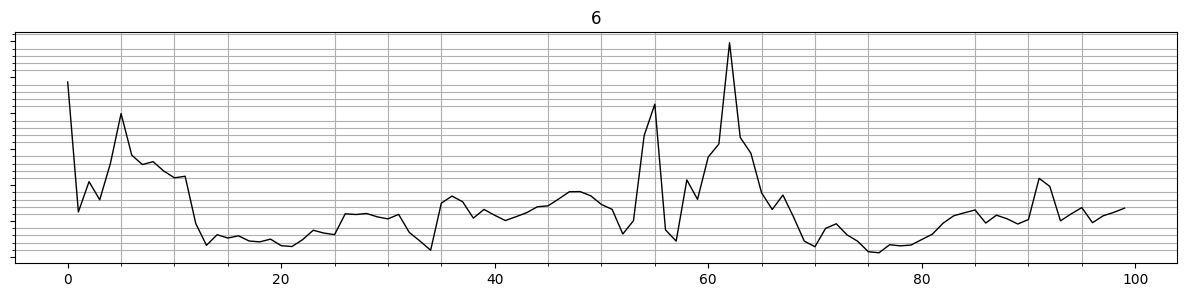

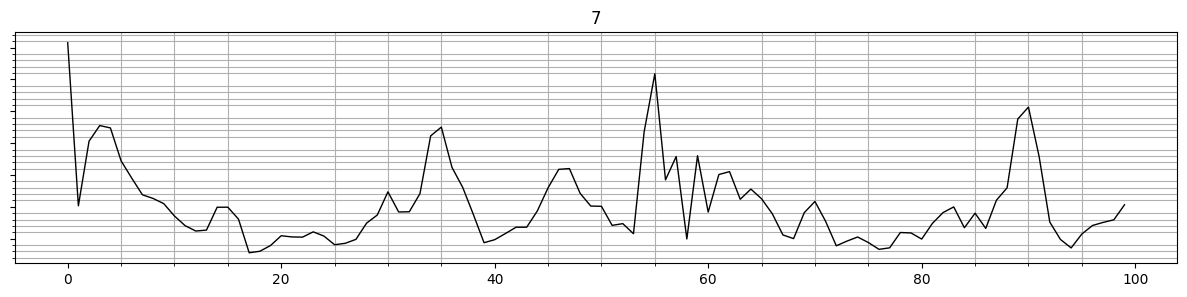

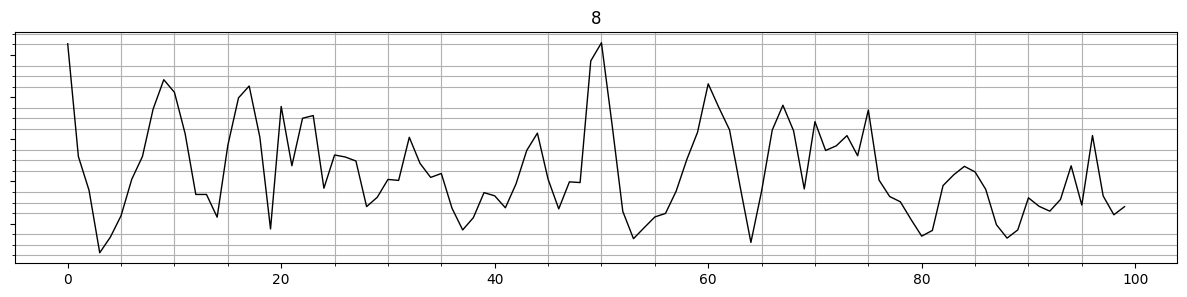

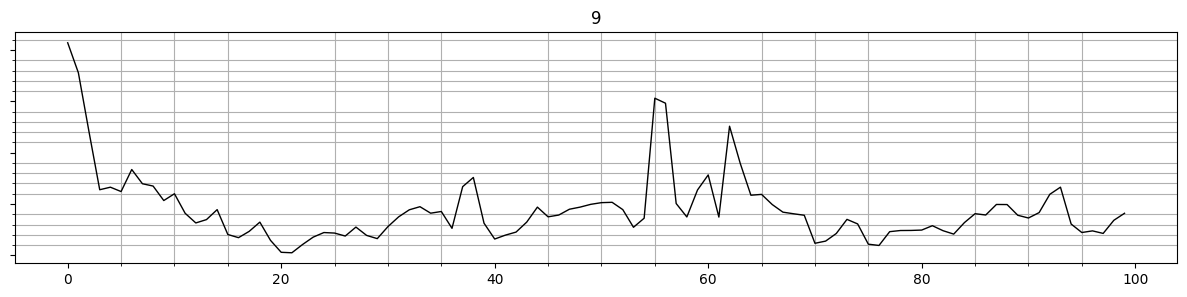

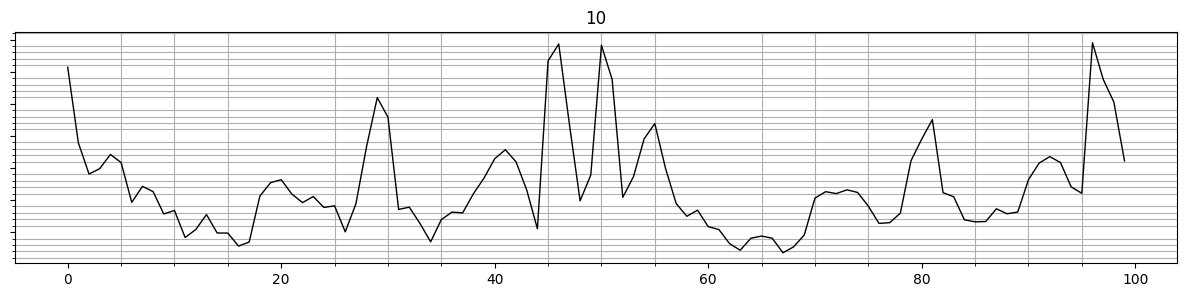

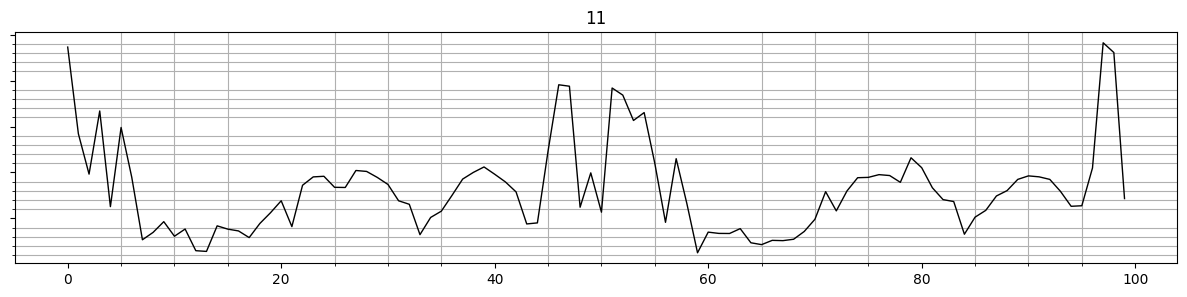

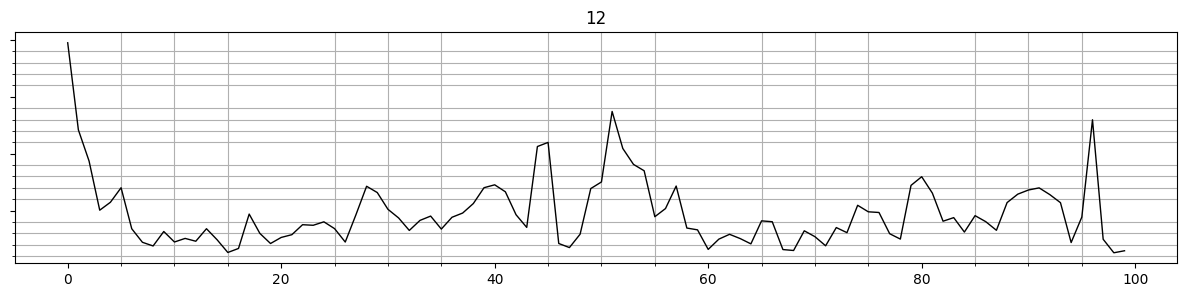

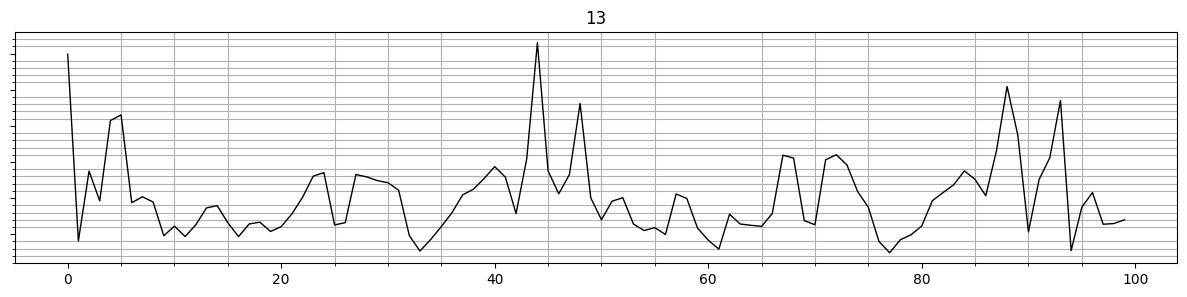

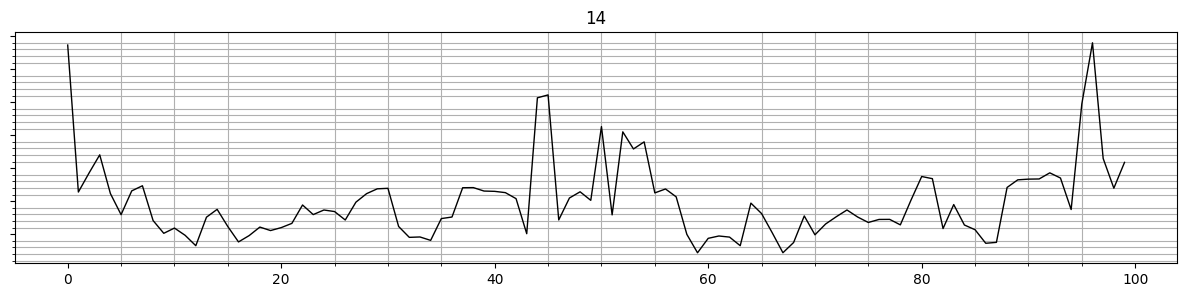

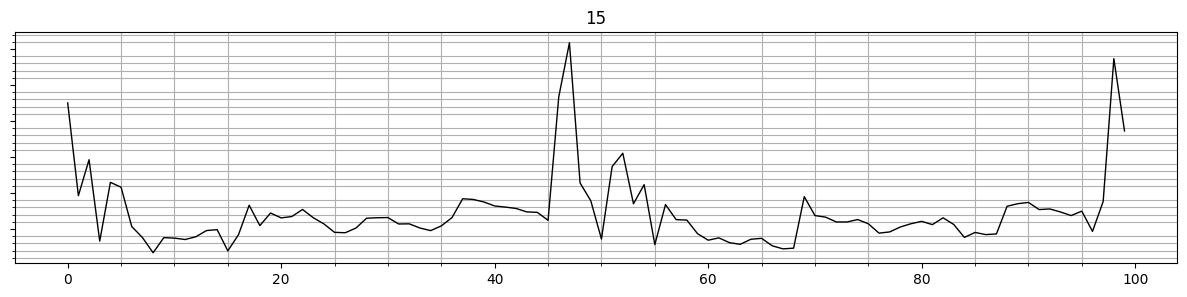

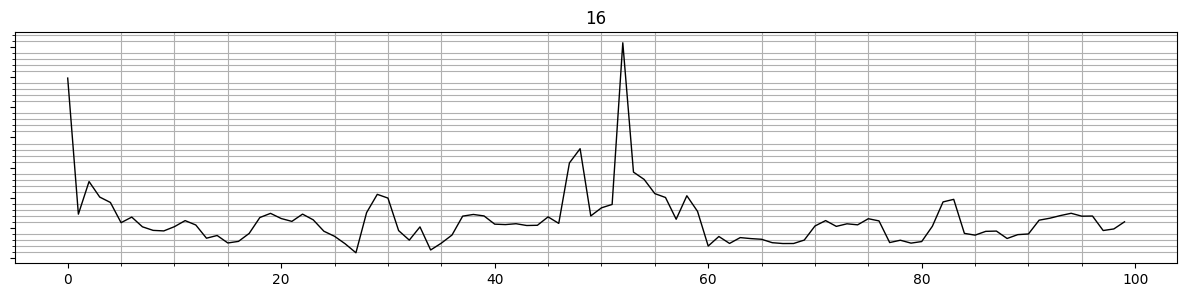

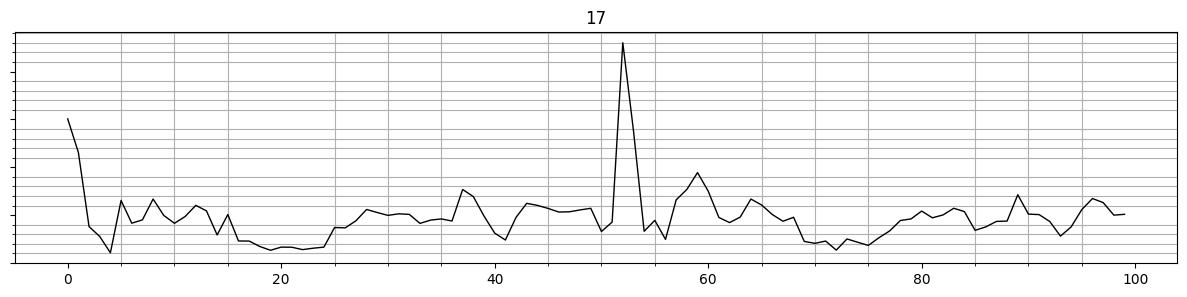

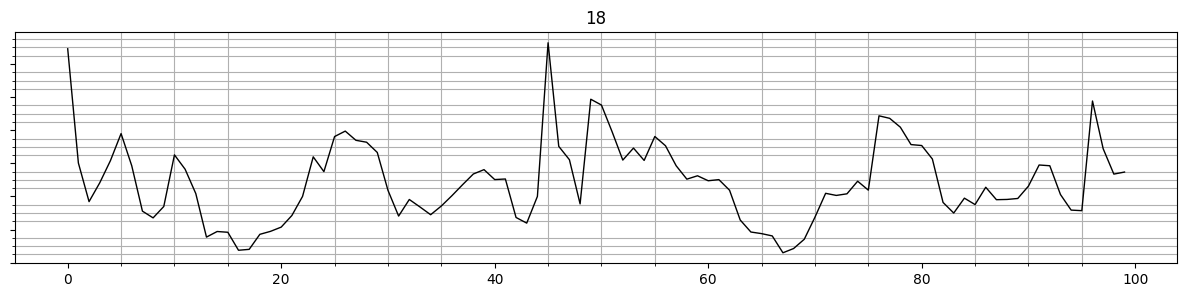

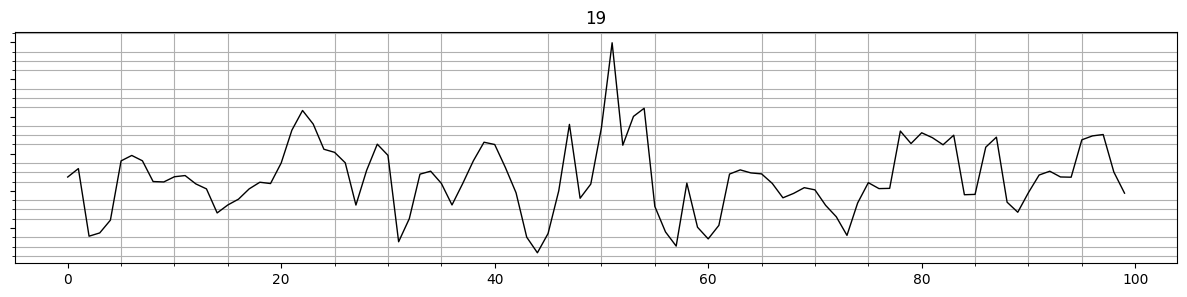

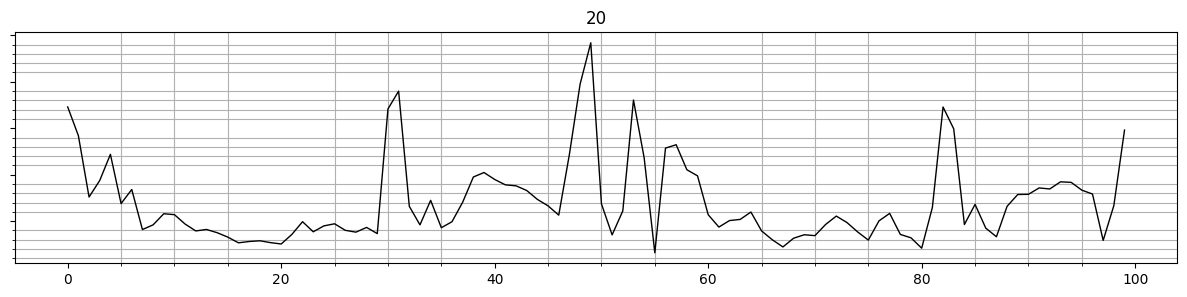

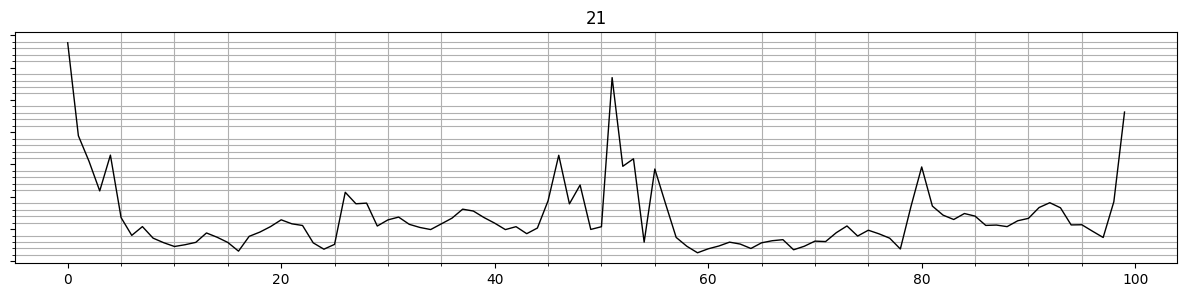

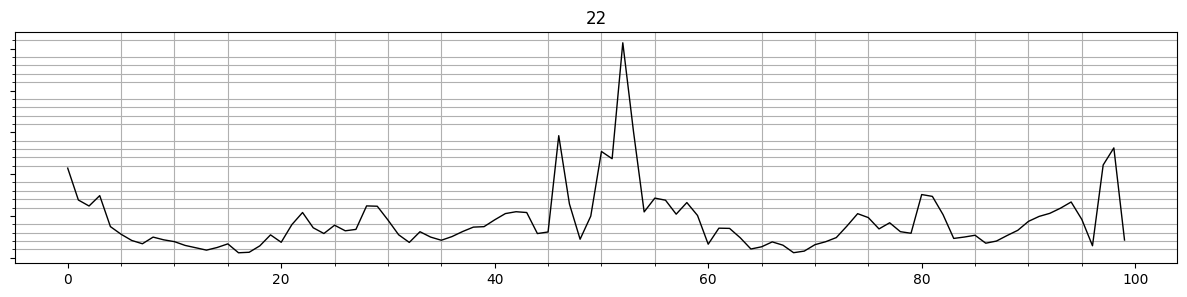

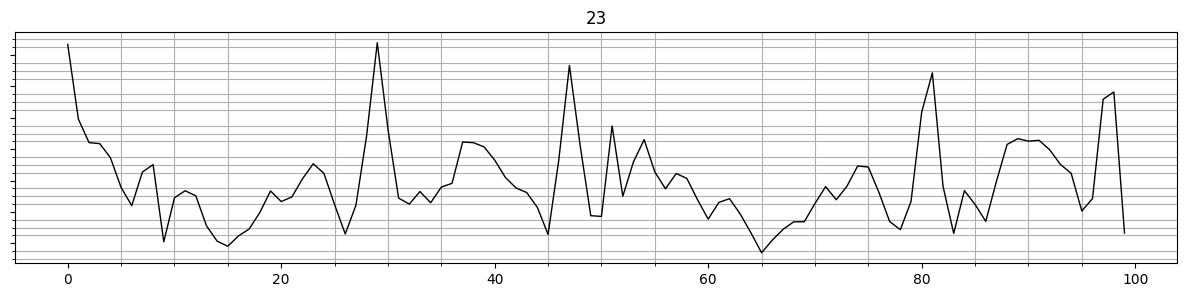

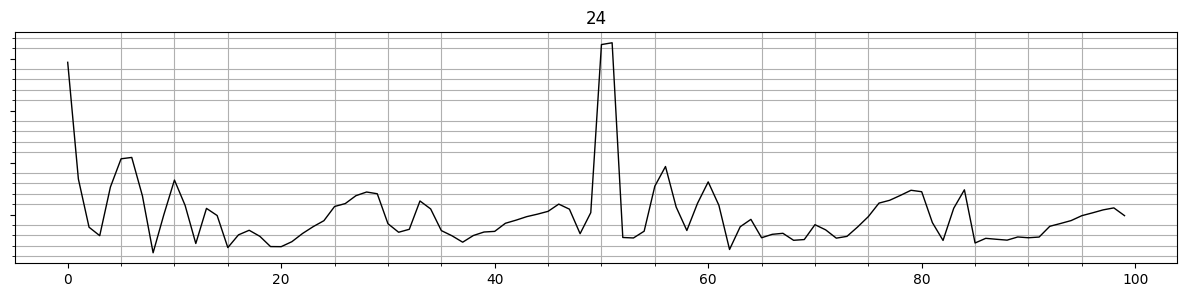

In [45]:
for person in range(1,25):
    ts = make_ts(person, 'wlk_15')[global_start_point+person_start_point_map_500[person]:global_end_point]
    plt.figure(figsize=(15,3))
    plt.plot(ts[:100], color = 'black', ls = '-', lw = 1)
    plt.title(person)
    plt.minorticks_on()
    plt.grid(which='minor')
    plt.tick_params(labelbottom=True, labelleft=False)
    plt.show()

In [46]:
t_span = [0, 500]
initial_state = [1.0, 1.0, 1.0]
ts = LorenzSystem().generate_data(initial_state, t_span)

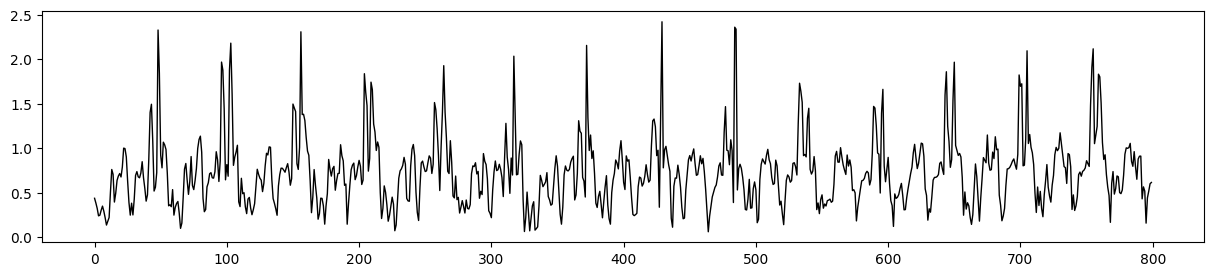

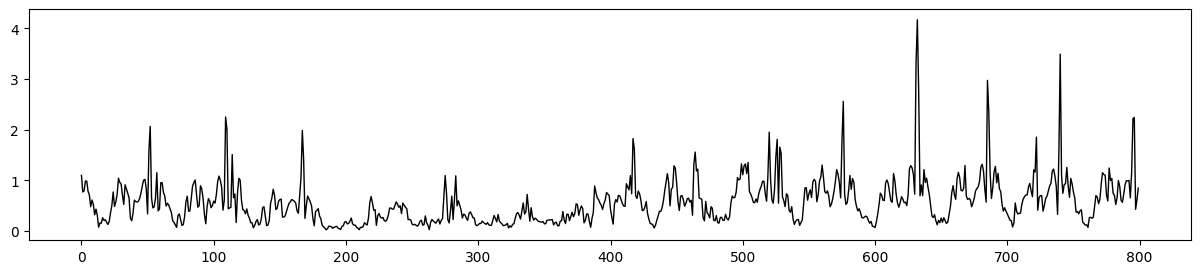

In [47]:
ts_1 = make_ts(1, 'wlk_7')
ts_2 = make_ts(4, 'wlk_7')

plt.figure(figsize=(15,3))
plt.plot(ts_1[:800], color = 'black', ls = '-', lw = 1)
plt.show()

plt.figure(figsize=(15,3))
plt.plot(ts_2[:800], color = 'black', ls = '-', lw = 1)
plt.show()

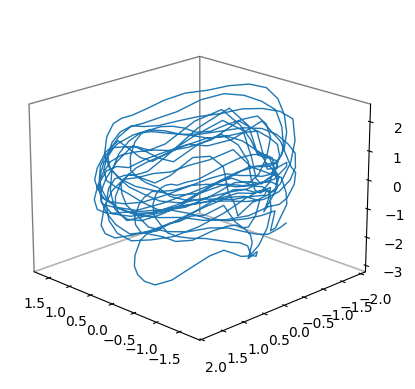

In [48]:
s = PCA(3).fit_transform(delay_embedding_matrix(ts_1, 50))
s =(s-s[:500,:].mean(axis=0))/s[:500,:].var(axis=0)**0.5
ax = plot_phase_trajectory(s[:500,:], rotation=(0, 0, 0))

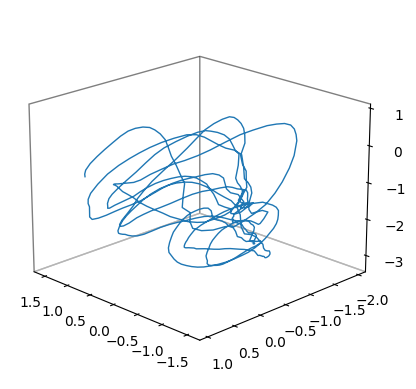

In [49]:
s = PCA(3).fit_transform(delay_embedding_matrix(ts_2, 50))
s =(s-s.mean(axis=0))/s.var(axis=0)**0.5
ax = plot_phase_trajectory(s[:500,:], rotation=(0, 0, 0))

In [50]:
theta_all =  pd.read_csv('./../data/A_DeviceMotion_data/data_subjects_info.csv').groupby('code').max()
theta_all = (theta_all - theta_all.mean())/(theta_all.var()**.5)
theta_columns = ['weight', 'height', 'age', 'gender']

In [51]:
list_S = []
list_model = []
min_lenth = np.inf
p = 6

for person in range(1,25):
    print(person, end=' ')
    ts = prepare_ts(person, 'wlk_15', global_start_point, global_end_point, person_start_point_map_500)
    X = delay_embedding_matrix(ts, 50)[500:]
    cur_min_lenth = X.shape[0]
    if cur_min_lenth < min_lenth:
        min_lenth = cur_min_lenth
        
    model = PCA(p).fit(X)
    S = model.transform(X)
    S =(S-S[:,:].mean(axis=0))/S[:,:].var(axis=0)**0.5

    list_model.append(model)
    list_S.append(S)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

In [52]:
J_all = {}
matrix_J_train = []
matrix_theta_train = []
matrix_J = []
matrix_theta = []

person_index = [(i, j) for i in range(0, 24) for j in range(0, 24)]

for i,j in person_index:
    J = compute_jacobian_matrix( S_new=list_S[j][:min_lenth,:], S_old=list_S[i][:min_lenth,:])
    J_all[(i,j)] = J
    # matrix_J_train.append((J - np.identity(p)).flatten())
    if i < 21 and j < 21:
        matrix_J_train.append(J.flatten())
        matrix_theta_train.append((theta_all.loc[i+1] - theta_all.loc[j+1]).values)
        
    matrix_J.append(J.flatten())
    matrix_theta.append((theta_all.loc[i+1] - theta_all.loc[j+1]).values)

matrix_J_train = np.array(matrix_J_train)
matrix_theta_train = np.array(matrix_theta_train)

matrix_J = np.array(matrix_J)
matrix_theta = np.array(matrix_theta)

In [53]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression

class LinearRegressionWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, p=1, fit_intercept=True, copy_X=True, n_jobs=None):
        self.p = p
        self.fit_intercept = fit_intercept
        self.copy_X = copy_X
        self.n_jobs = n_jobs
        
    def fit(self, X, y):
        self.model_ = LinearRegression(
            fit_intercept=self.fit_intercept,
            copy_X=self.copy_X,
            n_jobs=self.n_jobs
        )
        self.model_.fit(X, y)

        self.coef_ = self.model_.coef_
        return self
        
    def predict(self, X):
        delta_X = self.model_.predict(X)
        # X = np.identity(self.p)+delta_X.reshape(self.p,self.p)
        X = delta_X.reshape(self.p,self.p)
        return X
    
    def score(self, X, y):
        return self.model_.score(X, y)

In [54]:
model = LinearRegressionWrapper(p=p, fit_intercept = True)
model = model.fit(X=matrix_theta_train, y=matrix_J_train)
matrix_J_train.shape, matrix_theta_train.shape

((441, 36), (441, 4))

In [55]:
def find_nearest_system(theta_new, pd_theta_train):
    nearest_idx = (df['values'] - target_value).abs().idxmin()
    nearest_value = df.loc[nearest_idx, 'values']

# Точность на обучающей выборке

In [56]:
i,j = (3,6)
hat_J = model.predict((theta_all.loc[i+1] - theta_all.loc[j+1]).values[np.newaxis, :])
J = (np.identity(p) if i == j else J_all[(i, j)])

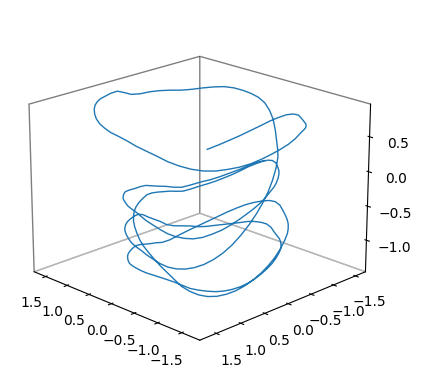

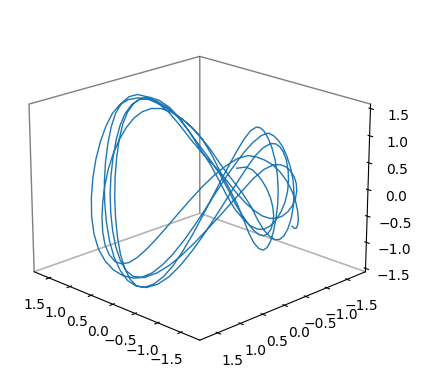

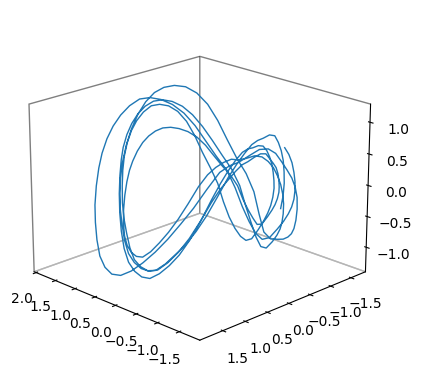

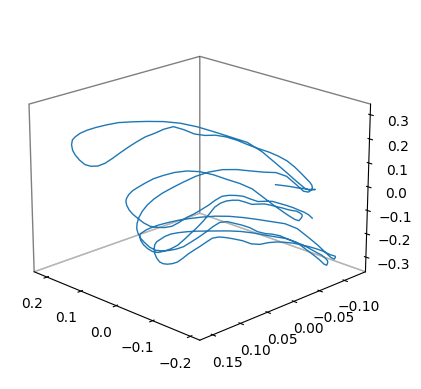

In [57]:
_ = plot_phase_trajectory(phase_trajectory=(list_S[i][:min_lenth,:])[:700,:3])
_ = plot_phase_trajectory(phase_trajectory=(list_S[j][:min_lenth,:])[:700,:3])
_ = plot_phase_trajectory(phase_trajectory=(list_S[i][:min_lenth,:] @ J)[:700,:3])
_ = plot_phase_trajectory(phase_trajectory=(list_S[i][:min_lenth,:] @ hat_J)[:700,:3])

# Точность на новых временных рядах

In [58]:
i,j = (None, 23)

theta_new = theta_all.loc[j]
pd_theta_train = theta_all.loc[theta_all.index < 21]
i = (((pd_theta_train-theta_new)**2).sum(axis=1)**0.5).idxmin()


hat_J = model.predict((theta_all.loc[i+1] - theta_all.loc[j+1]).values[np.newaxis, :])
J = (np.identity(p) if i == j else J_all[(i, j)])

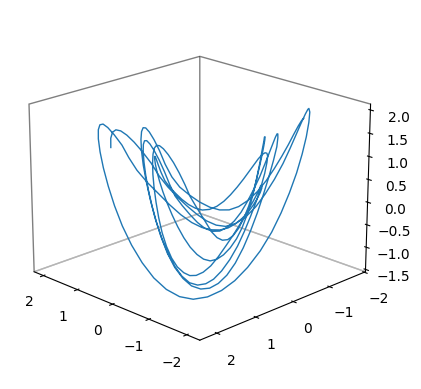

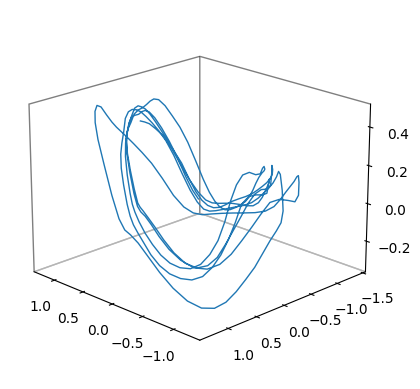

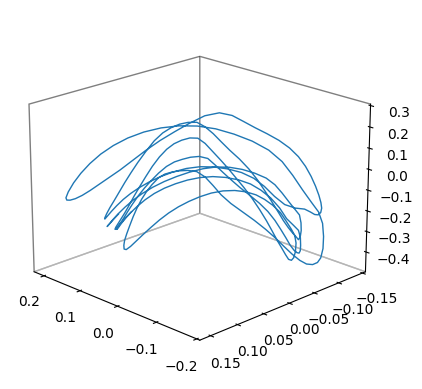

In [59]:
_ = plot_phase_trajectory(phase_trajectory=(list_S[j][:min_lenth,:])[:700,:3])
_ = plot_phase_trajectory(phase_trajectory=(list_S[i][:min_lenth,:] @ J)[:700,:3])
_ = plot_phase_trajectory(phase_trajectory=(list_S[i][:min_lenth,:] @ hat_J)[:700,:3])
# _ = plot_phase_trajectory(phase_trajectory=(list_S[i][:min_lenth,:])[:700,:3])

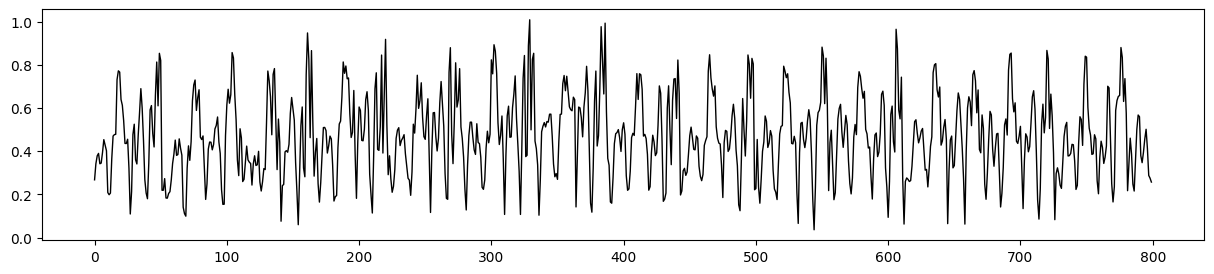

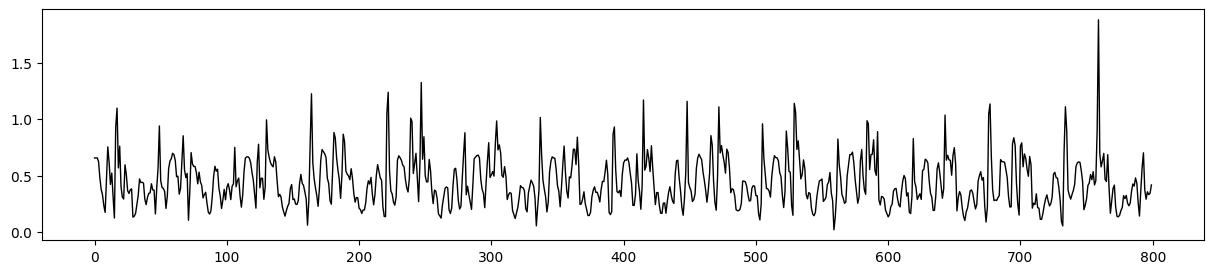

In [60]:
ts_1 = make_ts(i, 'wlk_7')
ts_2 = make_ts(j, 'wlk_7')

plt.figure(figsize=(15,3))
plt.plot(ts_1[:800], color = 'black', ls = '-', lw = 1)
plt.show()

plt.figure(figsize=(15,3))
plt.plot(ts_2[:800], color = 'black', ls = '-', lw = 1)
plt.show()

In [61]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

def hausdorff_distance(A, B):
    """
    Вычисляет расстояние Хаусдорфа между двумя наборами точек
    
    Args:
        A, B: numpy arrays формы (n_points, n_dimensions)
    
    Returns:
        hausdorff_dist: расстояние Хаусдорфа
    """
    # Вычисляем матрицу попарных расстояний
    dist_matrix = cdist(A, B, metric='euclidean')
    
    # max(min(dist(a,B))) для всех a в A
    dist_A_to_B = np.max(np.min(dist_matrix, axis=1))
    
    # max(min(dist(b,A))) для всех b в B  
    dist_B_to_A = np.max(np.min(dist_matrix, axis=0))
    
    return max(dist_A_to_B, dist_B_to_A)

def wasserstein_distance(A, B):
    """
    Вычисляет расстояние Васерштейна (Earth Mover's Distance) между двумя наборами точек
    
    Args:
        A, B: numpy arrays одинаковой формы (n_points, n_dimensions)
    
    Returns:
        wasserstein_dist: расстояние Васерштейна
    """
    # Матрица попарных расстояний
    dist_matrix = cdist(A, B, metric='euclidean')
    
    # Решаем задачу назначения (assignment problem)
    row_ind, col_ind = linear_sum_assignment(dist_matrix)
    
    # Сумма расстояний оптимального назначения
    wasserstein_dist = dist_matrix[row_ind, col_ind].sum() / len(row_ind)
    
    return wasserstein_dist

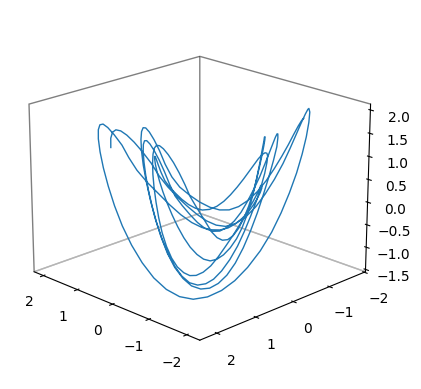

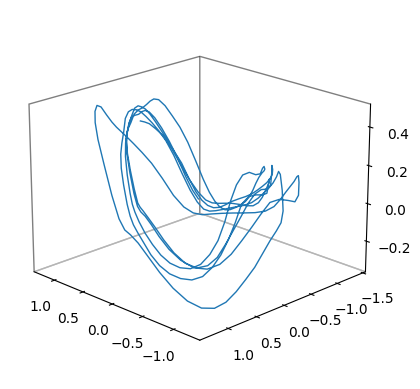

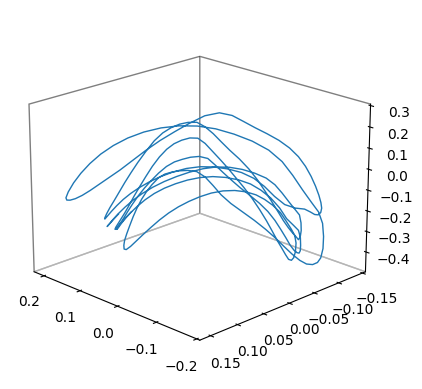

In [62]:
_ = plot_phase_trajectory(phase_trajectory=(list_S[j][:min_lenth,:])[:700,:3])
_ = plot_phase_trajectory(phase_trajectory=(list_S[i][:min_lenth,:] @ J)[:700,:3])
_ = plot_phase_trajectory(phase_trajectory=(list_S[i][:min_lenth,:] @ hat_J)[:700,:3])

In [63]:
i,j = (None, 19)

theta_new = theta_all.loc[j]
pd_theta_train = theta_all.loc[theta_all.index < 21]
i = (((pd_theta_train-theta_new)**2).sum(axis=1)**0.5).idxmin()


hat_J = model.predict((theta_all.loc[i+1] - theta_all.loc[j+1]).values[np.newaxis, :])
J = (np.identity(p) if i == j else J_all[(i, j)])

In [64]:
hat_J.round(2)

array([[ 0.04,  0.02, -0.01, -0.  , -0.01, -0.  ],
       [ 0.03,  0.08,  0.01, -0.  ,  0.  , -0.01],
       [ 0.  ,  0.01,  0.14,  0.02,  0.03, -0.  ],
       [ 0.  , -0.  ,  0.03,  0.04,  0.02,  0.  ],
       [-0.  ,  0.  ,  0.05,  0.02,  0.06,  0.  ],
       [ 0.  , -0.  , -0.  ,  0.  ,  0.  ,  0.04]])

In [65]:
S_true = list_S[j][:min_lenth,:][:700,:]
S_near = list_S[i][:min_lenth,:][:700,:]
# S_all_lin = 
S_suggest = (list_S[i][:min_lenth,:] @ hat_J)[:700,:]

S_true = (S_true-S_true.mean(axis=0))/S_true.var(axis=0)**0.5
S_true = (S_near-S_near.mean(axis=0))/S_near.var(axis=0)**0.5
S_true = (S_suggest-S_suggest.mean(axis=0))/S_suggest.var(axis=0)**0.5

print(f"Расстояние от ближайшего по параметрам {hausdorff_distance(S_true, S_near)} и {wasserstein_distance(S_true, S_near)}")
# print(f"Расстояние для линейной модели с учетом парамеров {hausdorff_distance(A, B)} и {}")
print(f"Расстояние для предложенного метода {hausdorff_distance(S_true, S_suggest)} и {wasserstein_distance(S_true, S_suggest)}")

Расстояние от ближайшего по параметрам 3.332781719632287 и 1.4766841336423624
Расстояние для предложенного метода 4.332305730900587 и 2.2021867102464623
